# Tutorial 0c: CTSM Evaluations at NEON Tower Sites

This tutorial is an introduction to evaluating CTSM at a NEON tower site.  It provides example visualizations and evaluation of simulated latent heat flux using NEON tower observations.  This tutorial uses results from the case you ran in the Day0b tutorial, but you don't have to wait for those runs to complete before doing this tutorial. We've pre-staged model results from this simulation in a shared directory so that you can analyze results of your simulations regardless of whether they've completed.

------

**This tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see the [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 

***

## In this tutorial :

The tutorial has several components. Below you will find steps and instructions to:
1. Become familiar with Jupyter notebooks
1. Begin getting acquainted with python packages and their utilities
1. Explore CLM model data
1. Explore NEON observation data
1. Compare CLM and NEON latent heat flux data

________
# 1. Explore CLM model data

There are countless ways of analyzing and processing model data. This tutorial uses Matplotlib, a comprehensive data visualization and plotting library for Python. For more information on Matplotlib, please see the [User's Guide](https://matplotlib.org/stable/users/index.html).

Before diving in, set the NEON site that you simulated in the cell below. As a refresher, NEON tower sites include:

>ABBY, BART, BLAN, CPER, DCFS, DSNY, GRSM, HARV, JERC, JORN, KONZ, MOAB, NOGP, OAES, ORNL, OSBS, SCBI, SERC, SOAP, SRER, STEI, TALL, TREE, UKFS, UNDE, WOOD.  

*The tutorial is currently set to use the ABBY site. If you ran a simulation for a different tower site, please change the 4-character site name in quotes below to the same as your simulation.*

In [1]:
#Change the 4-character NEON site below to point to your NEON site:
neon_site = "ABBY"

***
## 1.1 Locate model data

When the simulation completes, the data are transferred to an `archive` directory. In this directory, there are files that include data for every day of the simulation, as well as files that average model variables monthly. <p>
    
In this tutorial, we are using pre-staged results, but the results should be identical to the NEON cases you just ran.
    
*Run the cell below to see a subset of the files listed:*

In [2]:
!ls ~/scratch/CLM-NEON/archive/ABBY.transient/lnd/hist |head -20

ABBY.transient.clm2.h0.2018-01.nc
ABBY.transient.clm2.h0.2018-02.nc
ABBY.transient.clm2.h0.2018-03.nc
ABBY.transient.clm2.h0.2018-04.nc
ABBY.transient.clm2.h0.2018-05.nc
ABBY.transient.clm2.h0.2018-06.nc
ABBY.transient.clm2.h0.2018-07.nc
ABBY.transient.clm2.h0.2018-08.nc
ABBY.transient.clm2.h0.2018-09.nc
ABBY.transient.clm2.h0.2018-10.nc
ABBY.transient.clm2.h0.2018-11.nc
ABBY.transient.clm2.h0.2018-12.nc
ABBY.transient.clm2.h0.2019-01.nc
ABBY.transient.clm2.h0.2019-02.nc
ABBY.transient.clm2.h0.2019-03.nc
ABBY.transient.clm2.h0.2019-04.nc
ABBY.transient.clm2.h0.2019-05.nc
ABBY.transient.clm2.h0.2019-06.nc
ABBY.transient.clm2.h0.2019-07.nc
ABBY.transient.clm2.h0.2019-08.nc
ls: write error: Broken pipe


Each line of the list above includes the file path (`/home/user/archive/{simulation_name}/lnd/hist/`) and file name. The file names are automatically generated and comprise:
* the simulation name, which includes:
    * the NEON site
    * the type of simulation 
        * The simulation you ran is "transient". This means the model was initialized and ran for the full length of available data. The initial conditions files for the transient tower simulations were created by cycling over 2018-2019 tower meteorological data. 
* the date of simulated data

The NEON tower simulations generate two types of files:
* `*h0*`: Variables that are averaged monthly. One file is available for every month of the simulation.
* `*h1*`: Variables that are recorded every 30 minutes. Values are aggregated into one file for each day of the simulation. Each file includes 48 data points.

**Note:** Only a subset of CLM variables are included on the `*h1*` files, with many more variables included on the monthly-averaged `*h0*` files. A full list of variables that are simulated by CLM is available [on this website](https://escomp.github.io/ctsm-docs/versions/master/html/users_guide/setting-up-and-running-a-case/master_list_nofates.html).

*Note that you can also find the model data in the 'Simulation' folder on your desktop, which was created as part of this tutorial.*
****


The files are saved in netcdf format (denoted with the `.nc` file extension), a file format commonly used for storing large, multi-dimensional scientific variables.
Netcdf files are platform independent and self-describing; each file includes metadata that describes the data, including: **variables**, **dimensions**, and **attributes**.

The figure below provides a generic example of the data structure in a netcdf file. The dataset illustrated has two variables (temperature and pressure) that have three dimensions. Coordinate data (e.g., latitude, longitude, time) that describe the data are also included. 

*Note that while each file for NEON tower simulations has multiple variables, the simulation ran for a single site rather than a larger spatial grid and therefore do not include the latitude and longitude dimensions illustrated here. Within each multi-variable file, most of the variables have one dimension (time), while a few soil variables (e.g., moisture, temperature) have two dimensions (time x depth).*

![Netcdf](https://gdfa.ugr.es/python/climate_data/img/xarray2.png)
****

## 1.2 Explore Simulated Data

This step has several components, which are broken into smaller steps. 


### 1.2.1 Load Python Libraries

To dig deeper into our model results, we'll use this notebook and some python packages to look at the data. 

*Run the below code to import the required python libraries*

In [6]:
#Import Libraries
%matplotlib inline

import os
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

#import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

from neon_utils import download_eval_files

### 1.2.2 Select Simulation Year

For simplicity, we focus on analyzing and evaluating a single year of data. <p>

The code below uses data for **2018**, but data are available through this year. You can select a different year by changing the year in the quotes below. <p> 
*Run the below code to identify the year of interest for making the plots. Note that the same year will be used to download observational data below*

In [7]:
#Specify the year below
year = "2018"

Paths are different for every user based on their usernames, so we get the username to use for paths:


In [8]:
username = os.environ['USER'] 

### 1.2.3 Load model data files

For reading the netCDF files, we are using the `xarray` Python package. You can learn more about [xarray on this website](http://xarray.pydata.org/en/stable/).

The variable `sim_path` points to the location where simulation data are stored.

*Run the code below to load the model data files. The code will print how many files were loaded*

In [9]:
sim_path = "/home/negins/scratch/CLM-NEON/archive/"+neon_site+".transient/lnd/hist/"
sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All Simulation files: [", len(sim_files), "files]")

All Simulation files: [ 365 files]


### 1.2.4 Open model data files

Here we use the python function `xarray.open_mfdataset`, which opens multiple netcdf files as a single xarray dataset. For more information on this xarray function, visit [the xarray website](
http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html).

*Run the below cell to read in the data files. Note that this step might take a few minutes.*

In [10]:
start = time.time()

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True)

end = time.time()
print("Reading all simulation files took:", end-start, "seconds.")

Reading all simulation files took: 57.751952171325684 seconds.


### 1.2.5 Optional Step: Explore dataset from simulations

This step looks at the dataset that was just created from the simulation data. This step is not required, but will allow you to explore the python dataset and become familiar with the data.

*Run the below cell to find more information about the data*

In [26]:
ds_ctsm

<xarray.Dataset>
Dimensions:       (time: 17520, levgrnd: 25, levsoi: 20, levlak: 10,
                   levdcmp: 25, hist_interval: 2, lndgrid: 1)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:29:59.12...
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/42)
    mcdate        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds   (time, hist_interval) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    ...            ...
    HR            (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    NET_NMIN_vr   (time, levdcmp, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    SOILC_vr      (time, levsoi, lndgrid) float32 dask.array<chunksize=(96, 20, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 07/28/22 16:16:53
    source:                               Community Terrestrial Systems Model
    hostname:                             aws-hpc6a
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30

In the output, you can click on `Dimensions`, `Coordinates`, `Data Variables`, and `Attributes` to expand and see the details and metadata associated with this dataset. 

If you click on `Data Variables`, you will see a list of all the available variables. You can click on the 'note' icon at the right end of the line for each variable to see a description of the variable (the `long_name`) and its `units`, as well as other information. Here are a few questions to consider:

**Questions to consider** 
1. What variables are available in the dataset?
2. What is the `long_name` and `unit` of the variable `FSH`? 
3. Can you find the dimensions of this variable? 

**💡 Tip**: 
Xarray has built-in plotting functions. For quick inspection of a variable, we can use `.plot()` to see it. The code below will make a basic plot of the Gross Primary Production (`GPP`) variable:

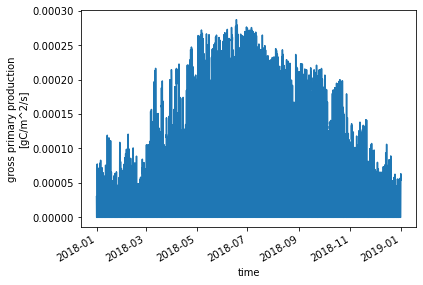

In [27]:
ds_ctsm['GPP'].plot()

You can select to plot only specific time period using .sel option.

For example,let’s check GPP for June of 2018:

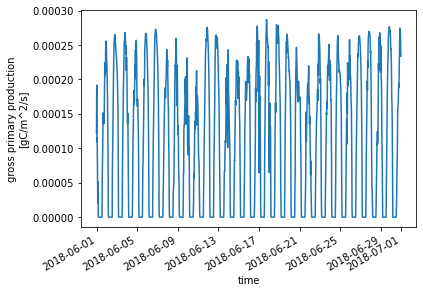

In [31]:
ds_ctsm.GPP.sel(time=slice('2018-06-01', '2018-06-30')).plot() ;

________
# 2. Explore NEON Tower Observation Data

## 2.1 Download NEON data

**A note about NEON evaluation data**: NEON data for evaluation are pulled from the API and the least restrictive quality control flags are applied. The data are subsequently gap-filled using a redundant data stream regression, while data that are still missing are filled using a Marginal Distribution Sampling (MDS) gap-filling technique. Unit conversions are performed and the data are formatted and supplied as monthly netCDF files. 


To download the data, this step uses a preestablished function (`download_eval_files`) to download the NEON observational data files for the site and year specified above. The preprocessed NEON data are available for download from NEON's S3 bucket, with the full listing of available data [here](https://s3.data.neonscience.org/neon-ncar/listing.csv).


>Note that this downloads the evaluation data based on the year you selected above. If you would like to download all available NEON evaluation data from this site, change the word `year` to `"all"` (quotes included) below: `download_eval_files(neon_site, eval_dir, "all")`


*Run the cell below to download available NEON data from the site you selected above.*

In [28]:
eval_dir = "/home/negins/scratch/evaluation_files/"

download_eval_files(neon_site, eval_dir, year)

Download finished successfully for listing.csv .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-01.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-02.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-03.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-04.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-05.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-06.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-07.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-08.nc .
Download finished successfully for /home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-09.nc .
Download finished successfully for /home/n

## 2.2 Load NEON data
   
*Run the two cells of code below. The code will print a list of files for the year specified above and read them into a dataset.*

In [14]:
eval_path = os.path.join(eval_dir,neon_site)

eval_files = sorted(glob(join(eval_path,neon_site+"_eval_"+year+"*.nc")))

print("All Observation files:")
print(*eval_files,sep='\n')

All Observation files:
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-01.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-02.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-03.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-04.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-05.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-06.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-07.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-08.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-09.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-10.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-11.nc
/home/negins/scratch/evaluation_files/ABBY/ABBY_eval_2018-12.nc


In [15]:
start = time.time()

ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

end = time.time()
print("Reading all observation files took:", end-start, "s.")

Reading all observation files took: 0.2886819839477539 s.


__________
# 3. Compare CLM and NEON latent heat flux data

So far, we uploaded files of observational and model data. In this section we will compare observed and simulated **latent heat fluxes**. You can also explore other available variables with this code.
***

### Format Data
The next cell of code processes the data into a common format to make analysis easier.
<br/>

**A note about model timestamps:** The CTSM history includes an initial 0th timestep for each model simulation. This offset in the time dimension can cause challenges when analyzing and evaluating model data if not treated properly. You may notice in the last line of the below cell, we shift the value by -1 to address this issue.

*Run the below cell of code to extract the variables needed for this notebook and create a single dataframe that includes all the extracted variables*

In [16]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['FCEV', 'FCTR', 'FGEV']

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})

for var in ctsm_vars:
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[var]=field


#Convert NEON data to a Pandas Dataframe for easier handling:
eval_vars = ['EFLX_LH_TOT']

df_eval = pd.DataFrame({'time':ds_eval.time})

for var in eval_vars:
    field = np.ravel ( ds_eval[var])     
    df_eval[var]=field

#-- make df_all that includes both obs and sim
df_all = df_eval

#-- add simulation data to df_all and adjust for offset time dimension:
for var in ctsm_vars:
    sim_var_name = "sim_"+var
    #-- shift simulation data by one
    df_all[sim_var_name]=df_ctsm[var].shift(-1).values

*The next cell gives us a quick look at the dataframe to make sure the data are available*

In [17]:
df_all.head()

,time,EFLX_LH_TOT,sim_FCEV,sim_FCTR,sim_FGEV
0,2018-01-01 00:00:00,7.999955,-7.638256,3.530287e-15,6.177156
1,2018-01-01 00:30:00,9.523534,-9.999990,5.481304e-17,8.121943
2,2018-01-01 01:00:00,9.358360,-8.272109,0.000000e+00,7.193619
3,2018-01-01 01:30:00,5.013022,-7.173703,0.000000e+00,6.415616
4,2018-01-01 02:00:00,2.368721,-7.002047,0.000000e+00,6.262211


## 3.1 What is latent heat flux?

Below we explore how well CLM simulates latent heat flux, which is directly observed at NEON towers. Latent heat flux is the energy for water evaporation from the ecosystem. Latent heat flux is a combination of plant transpiration, evaporation from leaf surfaces (e.g., from dew, after precipitation events, etc.), and evaporation from the soil:

$$ Latent Heat Flux = Transpiration + Canopy Evaporation + Ground Evaporation $$

Although NEON towers cannot distinguish how much each of these processes contributes to latent heat flux, CLM simulations can help us to disentangle the role of each. 

First we will calculate latent heat flux simulated by CLM by summing the component fluxes in the above equation. The CLM variables are:

>$FCEV$: Canopy evaporation (W m<sup>-2</sup>) <br>
>$FCTR$: Canopy transpiration (W m<sup>-2</sup>) <br>
>$FGEV$: Ground evaporation (W m<sup>-2</sup>) <br>

*Run the below cell to calculate simulated latent heat flux*

In [18]:
clm_var = 'sim_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_all['sim_FCEV'] \
                 + df_all['sim_FCTR']\
                 + df_all['sim_FGEV']

df_all.head()

,time,EFLX_LH_TOT,sim_FCEV,sim_FCTR,sim_FGEV,sim_EFLX_LH_TOT
0,2018-01-01 00:00:00,7.999955,-7.638256,3.530287e-15,6.177156,-1.461100
1,2018-01-01 00:30:00,9.523534,-9.999990,5.481304e-17,8.121943,-1.878047
2,2018-01-01 01:00:00,9.358360,-8.272109,0.000000e+00,7.193619,-1.078490
3,2018-01-01 01:30:00,5.013022,-7.173703,0.000000e+00,6.415616,-0.758087
4,2018-01-01 02:00:00,2.368721,-7.002047,0.000000e+00,6.262211,-0.739835


******************
### Optional:
If you are unfamiliar with reading and using the netcdf file format that model and evaluation data are provided, you can save data different formats. The next cell of code will save the pre-processed data in `.csv`, or comma-seperated file format. 


In [19]:
csv_dir = os.path.join("/home", username, "preprocessed_data")

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

csv_out = os.path.join(csv_dir, "preprocessed_"+neon_site+"_"+year+".csv")
df_all.to_csv(csv_out,index=False)

****
## 3.2 Plotting latent heat flux

### 3.2.1 Daily Timeseries
This creates a time-series plot comparing daily average latent heat flux from observations (NEON) and simulations (CLM). To start, we need calculate the daily averages. Run the below cells of code to create the averages and plot.

*First, we need to extract year, month, day and hour from time column*

In [20]:
#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

*Next, calculate daily averages*

In [21]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])

Using the daily averages, we will create a plot using Python's [matplotlib package](https://matplotlib.org/)

*Run the below cell to create the plot:*

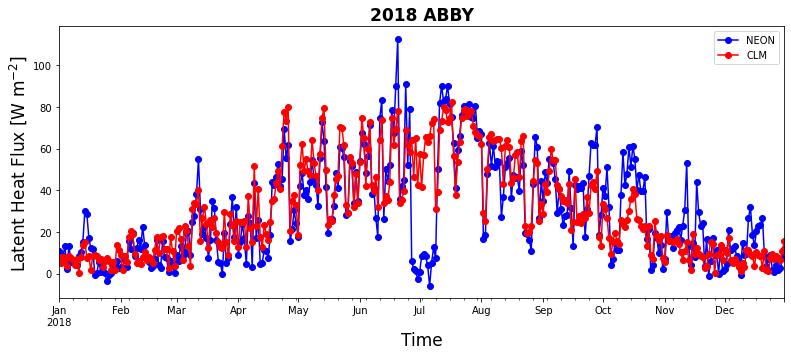

In [22]:
plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var

plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m$^{-2}$"

plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = 'b',label="NEON")
df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 'o' ,ax =ax , color = 'r',label="CLM")

plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

#### **Are the simulations and observations in the plot similar?**

It is important to also look at variability, as this gives us an indication of when and where simulations are outside the range of observed values. 

*Let's explore variability by adding the daily standard deviation as a shaded area to the plot*

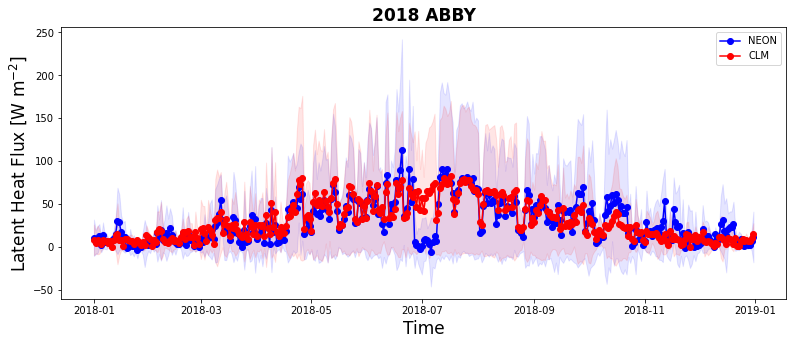

In [23]:
df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = 'b',label="NEON")
plt.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,alpha=0.1, color = 'b')
plt.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,alpha=0.1, color = 'r')

plt.legend()
plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

The standard deviation allows us to see when CLM underpredicts or overpredicts the NEON tower observations.

#### **Questions to consider:**

1. When is the latent heat hlux highest at this site? When is it lowest? <br>
1. Do fluxes simulated by CLM fall within the range of NEON tower observation variability? <br>
1. What times of year does CLM shows the best and worst performance in predicting latent heat flux ? <br>

*****
### 3.2.2 Monthly Averages & Component Fluxes: Absolute Values

Next we will disentangle whether transpiration, canopy evaporation, or ground evaporation is the dominant contribution to latent heat flux during each month using CLM data. As mentioned in section 3.1, NEON observations cannot distinguish how much each of these processes contributes to latent heat fluxes. 

*Run the cell below to calculate monthly averages*

In [24]:
df_monthly = df_all.groupby(['year','month']).mean().reset_index()
df_monthly["day"]=15
df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

##### Next, create a stacked bar chart showing components of simulated latent heat flux over different months

*Run the cell below to create the plot*

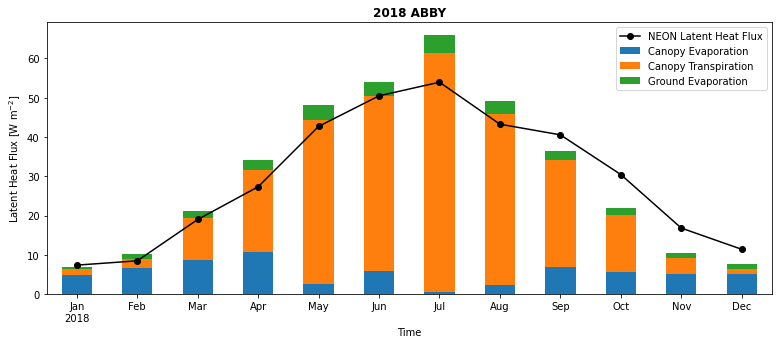

In [25]:
def line_format(label):
    """
    Helper function to convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month


plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax , color = 'black',label="NEON Latent Heat Flux",use_index=False)
df_monthly[['time','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))

#set labels for the legend
ax.legend(["NEON Latent Heat Flux", "Canopy Evaporation", "Canopy Transpiration", "Ground Evaporation"]);

plt.xlabel('Time')
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]")
        
plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

The monthly averages of NEON latent heat flux observation are plotted as a line on top of the barplot of CLM data for reference.

#### **Questions to consider:**

1. Which months does CLM overestimate and underestimate observed latent heat fluxes for this site? 
1. What times of year is *canopy transpiration* the largest contributor to the total CLM latent heat flux?
1. What times of year are *canopy evaporation* and *ground evaporation* important contributors to the total CLM latent heat flux? 
1. What is the dominant component flux when CLM overestimates observed latent heat fluxes? When CLM underestimates latent heat fluxes?
****

### 3.2.3 Monthly Averages & Component Fluxes: Proportional Contributions
It might be easier to see the proportional contributions of transpiration and evaporation fluxes to total latent heat flux. The code below makes a more advanced plot with two y-axes that helps to illustrate the absolute values of monthly latent heat fluxes and the proportion of component fluxes each month. 

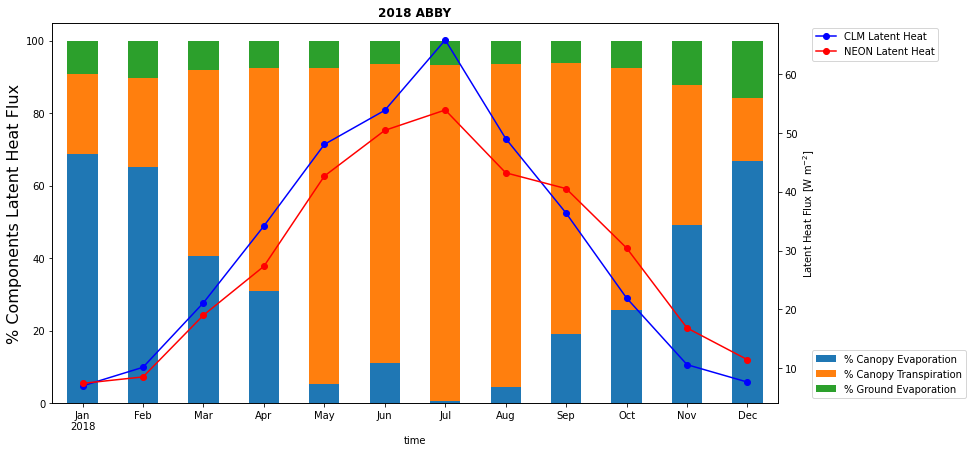

In [50]:
#-- calculate the percentage of total latent heat flux
df_monthly ['sim_FCEV_perc']= df_monthly ['sim_FCEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FCTR_perc']= df_monthly ['sim_FCTR']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FGEV_perc']= df_monthly ['sim_FGEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100

plt.figure(num=None, figsize=(13, 7),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly[['time','sim_FCEV_perc','sim_FCTR_perc','sim_FGEV_perc']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))
ax.set_ylabel('% Components Latent Heat Flux', fontsize=16)
ax.legend(bbox_to_anchor=(1.04,0), loc="lower left",labels=["% Canopy Evaporation","% Canopy Transpiration","% Ground Evaporation"])
ax2 = ax.twinx()
df_monthly.plot ( x= 'time', y = 'sim_EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'b',label="CLM Latent Heat",use_index=False)
df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'r',label="NEON Latent Heat",use_index=False)

plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

______________

### 3.2.4 Annual and Seasonal Correlations
Scatter plots can help to describe the relationship between latent heat flux and the component transpiration and evaporation fluxes. We can look at these relationships using data from CLM simulations.

First, plot annual average relationships.

*Run the cells below to first define a generic function that plot scatter diagrams and add a regression line, and then to generate the plots.*

In [51]:
#Defining generic function for scatter plots
def detailed_scatter (x, y, color):
    plt.scatter (x,y, marker="o",color = color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,line,'black', label='y={:.2f}x+{:.2f}'.format(slope,intercept)+" (R2="+"{:.2f}".format(r_value)+")")
    plt.legend(fontsize=13)

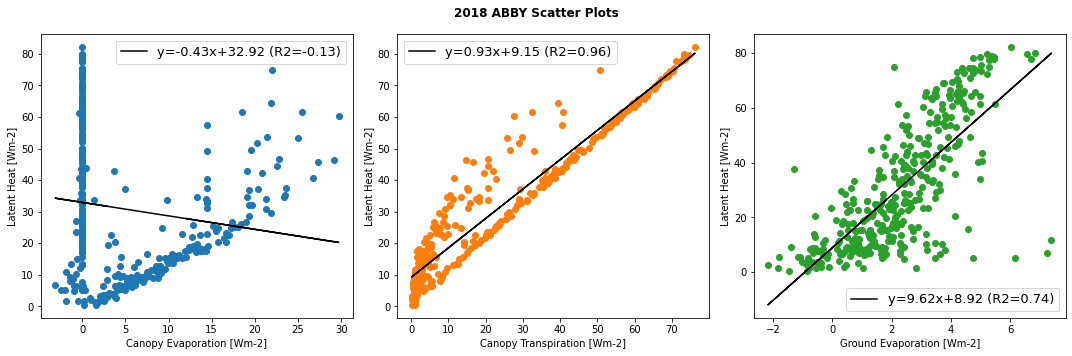

In [52]:
#Generating plots
plt.figure(num=None, figsize=(15, 5),  facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
detailed_scatter (df_daily.sim_FCEV, df_daily.sim_EFLX_LH_TOT, '#1f77b4')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(1, 3, 2)
detailed_scatter (df_daily.sim_FCTR, df_daily.sim_EFLX_LH_TOT, '#ff7f0e')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(1, 3, 3)
detailed_scatter (df_daily.sim_FGEV, df_daily.sim_EFLX_LH_TOT,'#2ca02c')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

plt.suptitle(year+" "+neon_site+" Scatter Plots", fontweight='bold')

plt.tight_layout()
plt.show()

****
Since the relationships between latent heat flux and the component transpiration and evaporation fluxes likely vary throughout the year, we can investigate how the relationships change during different seasons.

*Run the cell below to generate scatter plots by season*

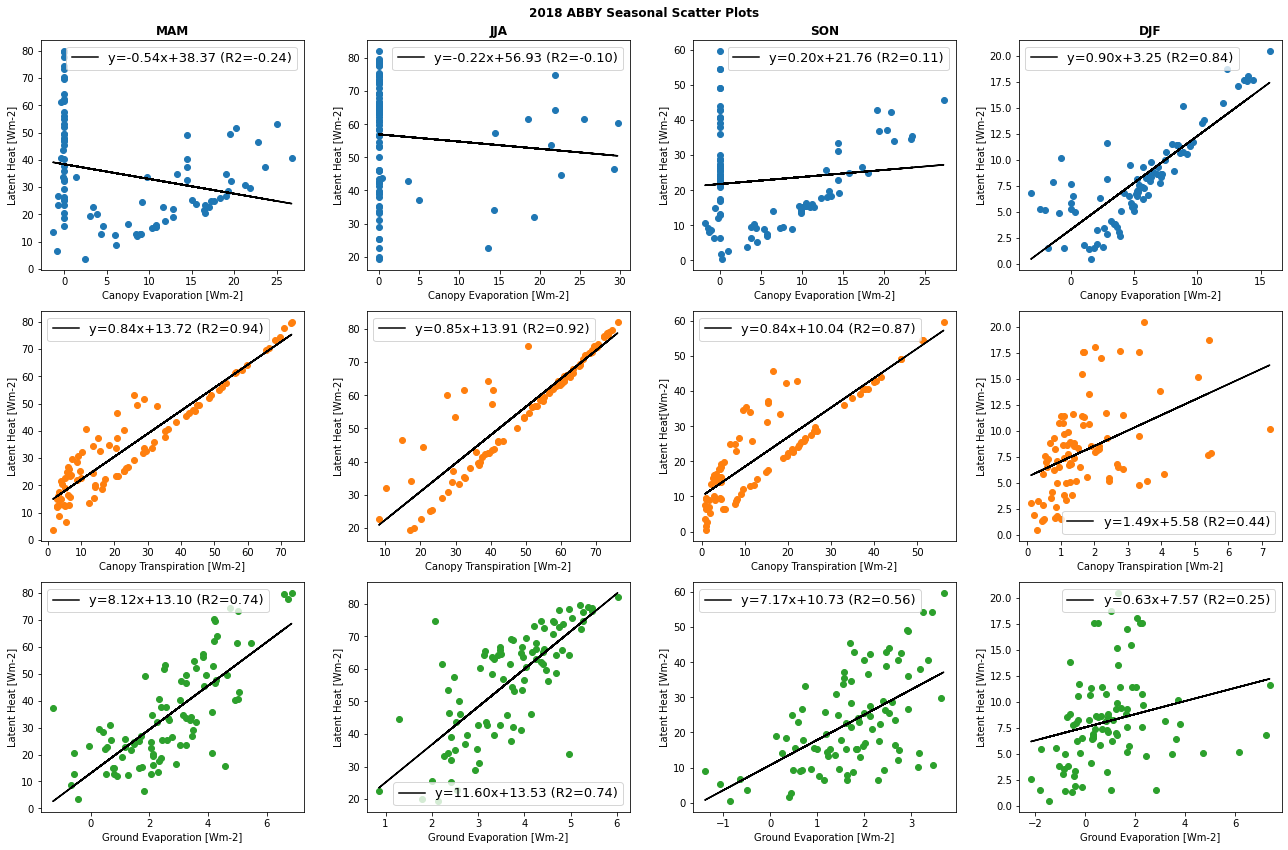

In [53]:
df_daily['season'] = ((df_daily['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

fig= plt.figure(num=None, figsize=(18,12),  facecolor='w', edgecolor='k')

season = 'MAM'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 1)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 5)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')


plt.subplot(3, 4, 9)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'JJA'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 2)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 6)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 10)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'SON'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 3)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 7)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat[Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 11)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

season = 'DJF'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 4)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 8)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 12)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT, '#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

fig.suptitle(year+" "+neon_site+ " Seasonal Scatter Plots", fontweight='bold')
fig.tight_layout()

plt.show()

--------
### 3.2.5 Average Diel Cycle

Latent heat flux also changes throughout the day. Does CLM capture the diel cycle that NEON observes? We can compare the average diel cycle from NEON observations and CLM simulations to find out. 

The `time` variable in the data is in Greenwich Mean Time (GMT). In the below plots, we adjust for the timezone so that the data are centered on local noon.


*Run the cell below to convert to local time*


In [54]:
tzone_shift = ds_eval.TimeDiffUtcLt
#convert to local time
df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))

df_all['local_hour'] = df_all['local_time'].dt.hour

*Run the cells below to calculate the annual average diel cycle and to generate a plot*

In [55]:
# Calculate annual average diel cycle and bias
diel_df_mean = df_all.groupby('local_hour').mean().reset_index()
diel_df_std = df_all.groupby('local_hour').std().reset_index()

diel_df_mean['EFLX_LH_TOT_bias'] = diel_df_mean['sim_EFLX_LH_TOT']- diel_df_mean['EFLX_LH_TOT']
diel_df_mean.head()

,local_hour,EFLX_LH_TOT,sim_FCEV,sim_FCTR,sim_FGEV,sim_EFLX_LH_TOT,year,month,day,hour,EFLX_LH_TOT_bias
0,0,2.213962,0.587655,0.009034,2.219624,2.816313,2018.0,6.526027,15.720548,8.0,0.602351
1,1,2.990461,0.807396,0.009065,2.127720,2.944182,2018.0,6.526027,15.720548,9.0,-0.046279
2,2,2.291917,0.914348,0.009230,2.079261,3.002839,2018.0,6.526027,15.720548,10.0,0.710923
3,3,1.841873,0.790320,0.009916,2.018334,2.818570,2018.0,6.526027,15.720548,11.0,0.976696
4,4,1.851197,0.970677,0.029630,1.968253,2.968560,2018.0,6.526027,15.720548,12.0,1.117363


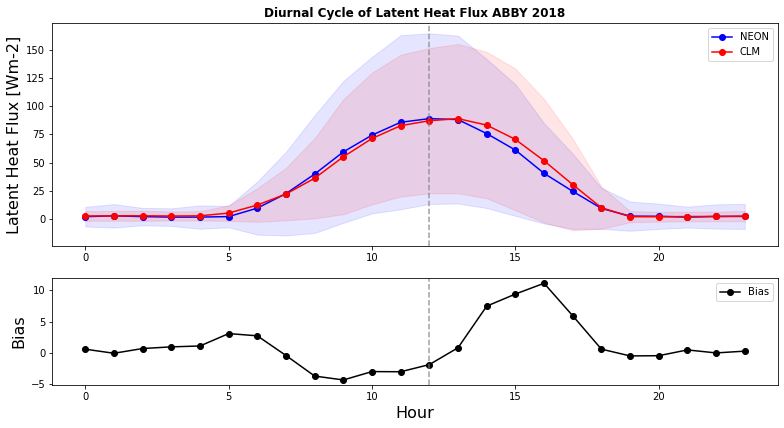

In [56]:
# Plot annual average diel cycle and bias
plt.figure(num=None, figsize=(13, 9),  facecolor='w', edgecolor='k')
        
plt.subplot(2, 1, 1)  
        
plt.plot ( diel_df_mean.local_hour, diel_df_mean[plot_var], marker = 'o' , color = 'b',label="NEON")
plt.plot ( diel_df_mean.local_hour, diel_df_mean[sim_var], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(diel_df_mean.local_hour, diel_df_mean[plot_var]-diel_df_std[plot_var], diel_df_mean[plot_var]+diel_df_std[plot_var] ,alpha=0.1, color = 'b')
plt.fill_between(diel_df_mean.local_hour, diel_df_mean[sim_var]-diel_df_std[sim_var], diel_df_mean[sim_var]+diel_df_std[sim_var] ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)
plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')
plt.legend()
plt.subplot(4, 1, 3)  

ax = plt.gca()    
diel_df_mean.plot ( x= 'local_hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax , color = 'black',label='Bias')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Bias', fontsize=16)
plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

plt.show()

#### How do transpiration and evaporation components of latent heat flux change throughout the day? 
We can add a panel to the above plot that shows how CLM partitioned latent heat flux to find out. 

*Run the cells below to add a panel to the plot*

In [57]:
#Calculating diel cycle flux proportions
diel_df_mean['sim_FCEV_perc']= diel_df_mean ['sim_FCEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FCTR_perc']= diel_df_mean ['sim_FCTR']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FGEV_perc']= diel_df_mean ['sim_FGEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100

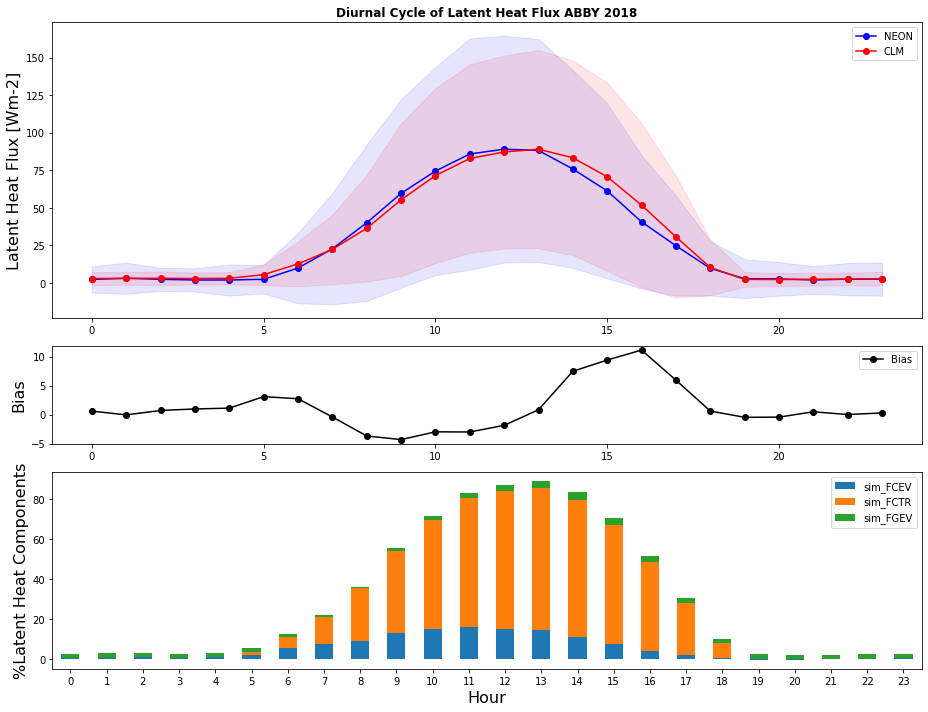

In [58]:
#plotting diel cycl flux proportions
from matplotlib import gridspec

fig= plt.figure(num=None, figsize=(13, 10),  facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 2]) 

ax0 = plt.subplot(gs[0])
        
ax0.plot ( diel_df_mean.local_hour, diel_df_mean['EFLX_LH_TOT'], marker = 'o' , color = 'b',label="NEON")
ax0.plot ( diel_df_mean.local_hour, diel_df_mean['sim_EFLX_LH_TOT'], marker = 'o' , color = 'r',label="CLM")

ax0.fill_between(diel_df_mean.local_hour, diel_df_mean[plot_var]-diel_df_std[plot_var], diel_df_mean[plot_var]+diel_df_std[plot_var] ,alpha=0.1, color = 'b')
ax0.fill_between(diel_df_mean.local_hour, diel_df_mean[sim_var]-diel_df_std[sim_var], diel_df_mean[sim_var]+diel_df_std[sim_var] ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)

plt.legend()
plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')

ax1 = plt.subplot(gs[1])
diel_df_mean.plot ( x= 'local_hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax1 , color = 'black',label='Bias')
plt.xlabel('', fontsize=18)
plt.ylabel('Bias', fontsize=16)

ax2 = plt.subplot(gs[2])
diel_df_mean[['local_hour','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'local_hour',stacked='True',ax=ax2,rot=0)
plt.ylabel('%Latent Heat Components', fontsize=16)
plt.xlabel('Hour', fontsize=16)

plt.tight_layout()

fig.show()

## Congratulations! You have:
1. Accessed the CTSM model data
1. Accessed the NEON observational data
1. Evaluated CTSM latent heat fluxes compared to NEON tower observations
1. Determined when transpiration and evaporation fluxes drive latent heat fluxes
1. Learned how to average over different time periods and create different types of plots

**If you would like to learn more advanced interactive visualization tools, please check back for an advanced tutorial that is coming soon!**

You can also use this script to explore additional CLM and NEON data by changing the variables in section 3 of this script.
